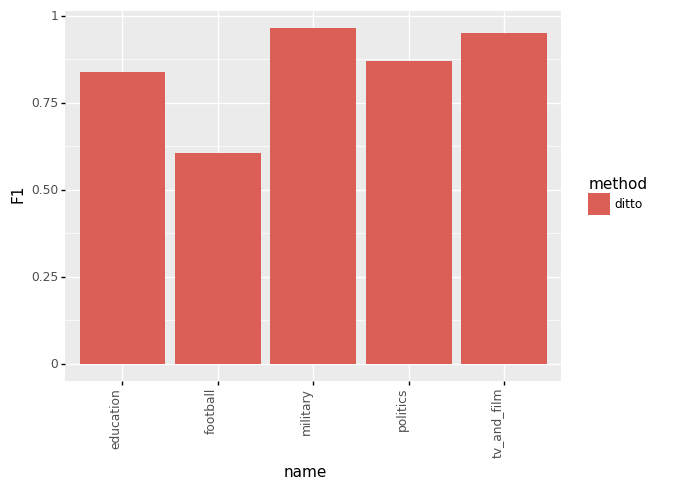

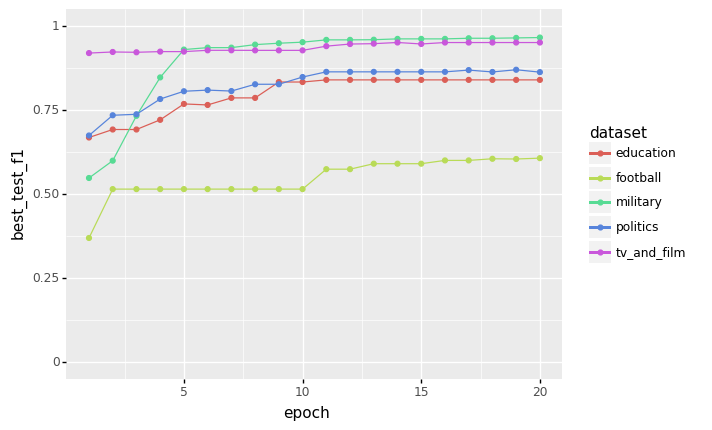

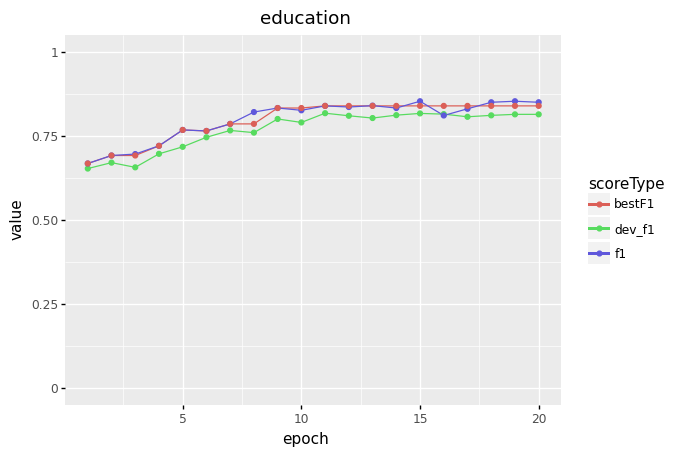

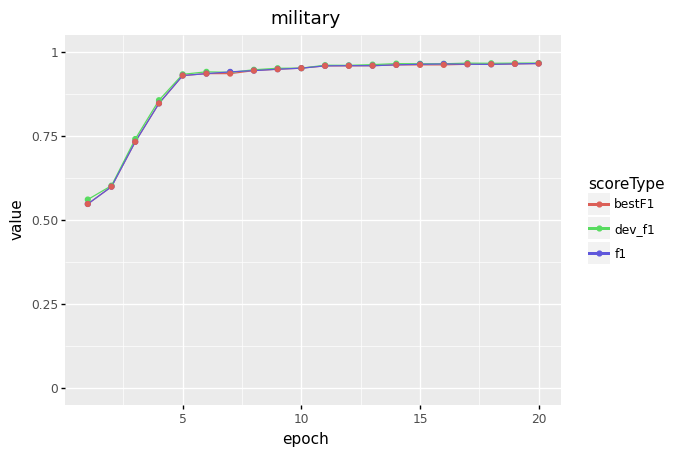

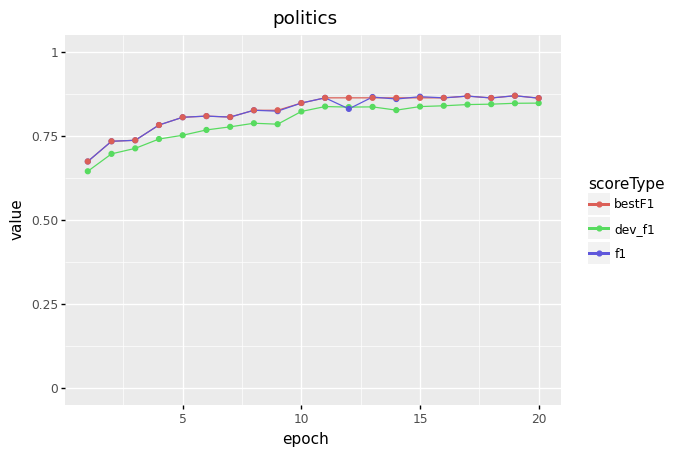

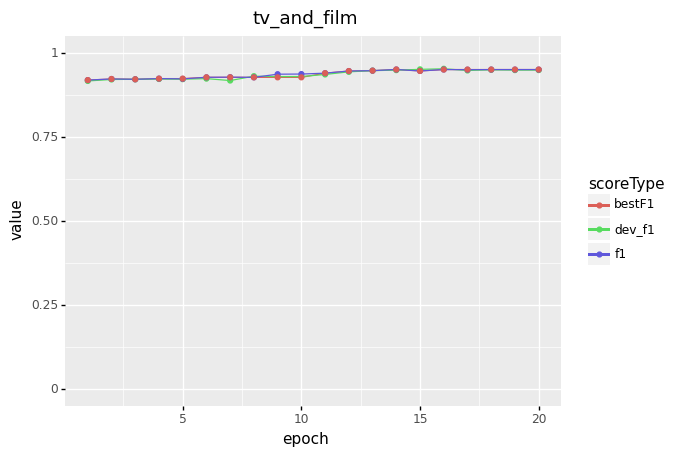

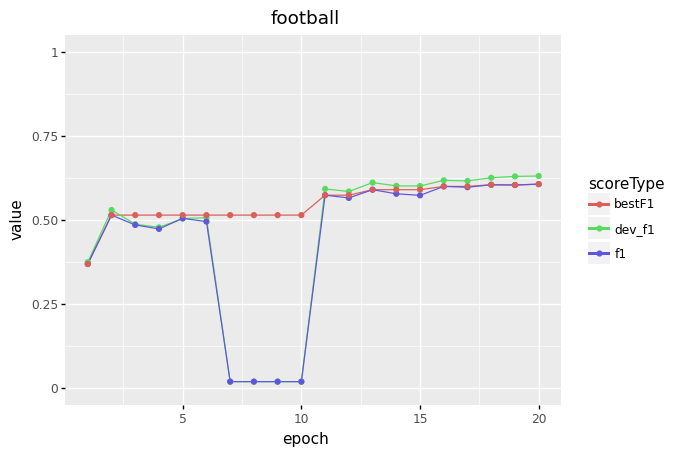

In [2]:
import pandas as pd
from plotnine import *
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve
import numpy as np



def readDittoDF(path,method):
    dittoDF = pd.read_csv(path)
    dittoDF["name"]=dittoDF["dataset"]
    dittoDF["F1"]=dittoDF["best_test_f1"]
    dittoDF["method"]=method
    return dittoDF

dittoDF = readDittoDF("localData/matching/dittoResults.csv","ditto")

dfPivoted = pd.read_csv("localData/matching/dittoResultsPivot.csv")

newDFToPlot = dittoDF
#print(ggplot(bestF1ScoreBased) + geom_point(aes(x='recall',y='Precision',color="name")))
plot = ggplot(newDFToPlot,aes(x = 'name',y='F1',fill='method')) + geom_col(position=position_dodge()) + theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)

plot = ggplot(dittoDF,aes(x = 'epoch',y='best_test_f1',color='dataset')) + geom_line() + geom_point()  + xlim(1, 20) + ylim(0, 1)
print(plot)

datasets = dittoDF["dataset"].unique()
for ds in datasets:
    dfFiltered = dfPivoted[dfPivoted["dataset"]==ds]
    #print(dfFiltered)
    plot = ggplot(dfFiltered,aes(x = 'epoch',y='value',color='scoreType')) + geom_line() +  geom_point() + ylim(0, 1) + xlim(1, 20) + ggtitle(ds)
    print(plot)


politics 0.8712871287128713 0.8870967741935484 0.8791208791208791 0.657258064516129


/tmp/ipykernel_7071/2405080210.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_7071/2405080210.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_7071/2405080210.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_7071/2405080210.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_7071/2405080210.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages

education 0.975 0.7905405405405406 0.8731343283582089 0.7972972972972973
tv_and_film 0.9853479853479854 0.9236051502145923 0.9534780682321667 0.9373390557939915
football 0.6976840363937138 0.8772750910036401 0.7772402672195347 0.0026001040041601664
military 0.9826809837201247 0.9491468718634996 0.9656228727025188 0.9611910337905654
Macro-F1 0.8897192831266617
Macro-F1 [0.657258064516129, 0.7972972972972973, 0.9373390557939915, 0.0026001040041601664, 0.9611910337905654] 0.6711371110804286
False
count     8852
unique       5
top         MI
freq      2978
Name: dataset, dtype: object


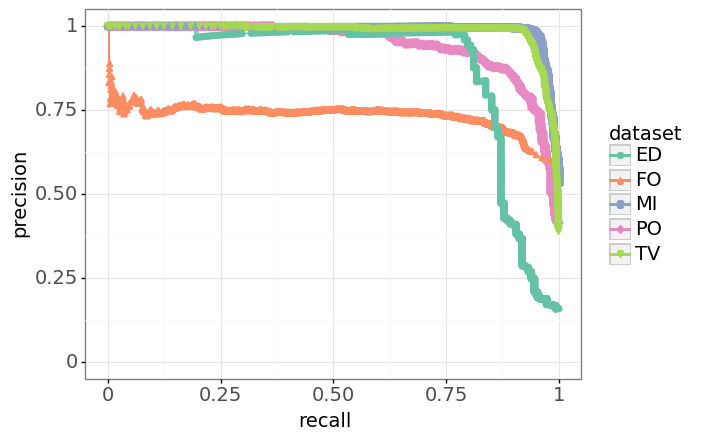

In [3]:
import role_matching.EvaluationHelperMethods as ehm
dsNames = ["politics", "education", "tv_and_film", "football","military"]

df = pd.DataFrame()
f1Scores = []
targetPrecision = 0.95
targetPrecisionRecalls = []
samplePoints = False
for dsName in dsNames:
    curDF = pd.read_csv("localData/dittoResults/"+dsName + ".csv")
    curDF["dataset"] = dsName
    p,r,t = precision_recall_curve(curDF["isTrueMatch"],curDF["normalizedScore"])
    tNEw = np.array(list(t) + [1.0])
    if(samplePoints):
        maxPoints = 50
        step = int(len(p) / maxPoints)
        indicesStart = [0]
        indicesRest = list(range(1,len(p),step))
        indicesLast = [len(p)-10,len(p)-9,len(p)-8,len(p)-7,len(p)-6,len(p)-5,len(p)-4,len(p)-3,len(p)-2,len(p)-1]
        print(indicesStart)
        print(indicesRest)
        p = np.array(p[indicesStart].tolist() + p[indicesRest].tolist() + p[indicesLast].tolist())
        r = np.array(r[indicesStart].tolist() + r[indicesRest].tolist() + r[indicesLast].tolist())
        tNEw = np.array(tNEw[indicesStart].tolist() + tNEw[indicesRest].tolist() + tNEw[indicesLast].tolist())
        # r = r[indices]
        # tNEw = tNEw[indices]
    f1 = (2*p*r) / (p + r)
    curPRdf = pd.DataFrame({"precision":p,"recall":r,"f1":f1,"threshold":tNEw,"dataset":dsName})
    #print(len(curDF['matchConfidence'].unique()),len(curDF.index))
    #print(curDF[curDF['matchConfidence']==0.9999698759401376])
    i = np.argmax(f1)
    f1Scores.append(f1[i])
    if(not samplePoints):
        targetPrecisionI = np.argwhere(p>=targetPrecision)
        recallsForTargetPrecision = r[targetPrecisionI]
        recallForTargetPrecision = np.max(recallsForTargetPrecision)
        targetPrecisionRecalls.append(recallForTargetPrecision)
        print(dsName,p[i],r[i],f1[i],recallForTargetPrecision)
    sorted = curPRdf.sort_values(by="threshold",ascending=False)
    #print(sorted)
    #plot = ggplot(curPRdf,aes(x = 'recall',y='precision',color='dataset')) + geom_line() + geom_point()  + xlim(0, 1) + ylim(0, 1)
    #print(plot)
    df = df.append(curPRdf)
if(not samplePoints):
    macroF1 = sum(f1Scores) / len(f1Scores)
    macroRecall = sum(targetPrecisionRecalls) / len(targetPrecisionRecalls)
    print("Macro-F1",macroF1)
    print("Macro-F1",targetPrecisionRecalls,macroRecall)
ehm.addShortDataset(df)
df["dataset"]=df["datasetShort"]
print(df['dataset'].isnull().values.any())
print(df['dataset'].describe())
plot = ggplot(df,aes(x = 'recall',y='precision',color='dataset',shape="dataset")) + geom_line() + geom_point(size=2) + xlim(0, 1) + ylim(0, 1) + theme_bw() + theme(text=element_text(size=14)) + scale_color_brewer(type="qual",palette="Set2")
plot.save("exportedPlots/prCurveMatching.png")
print(plot)

In [11]:
curDF = pd.read_csv("localData/dittoResults/football.csv")
print(len(curDF))
curDF = curDF[(~ (curDF["id1"].isnull())) & (~(curDF["id2"].isnull()))]
print(len(curDF))
curDF.sort_values("normalizedScore",inplace=True,ascending=False)
curDF.to_csv("tmp/toCheck.csv")
print(curDF)

3257
2317
                                                    id1  \
1322  football club infobox||6120799||65890575-0||le...   
238   football club infobox||3383256||53762368-0||body1   
6     football club infobox||6275438||67886061-0||le...   
2360  football club infobox||2312198||35976351-0||body2   
2684  football club infobox||893399||71689552-0||rig...   
...                                                 ...   
82    infobox football biography||38494734||53784553...   
1351  football player infobox||18785752||230836926-0...   
1894  infobox football biography||40104930||56632720...   
2181  football player infobox||22061260||278500227-0...   
1634  football player infobox||21478028||269781796-0...   

                                                    id2  isTrueMatch  \
1322  football club infobox||6120799||65890575-0||ri...         True   
238   football club infobox||3383256||53762368-0||so...         True   
6     football club infobox||6275438||67886061-0||ri...         T

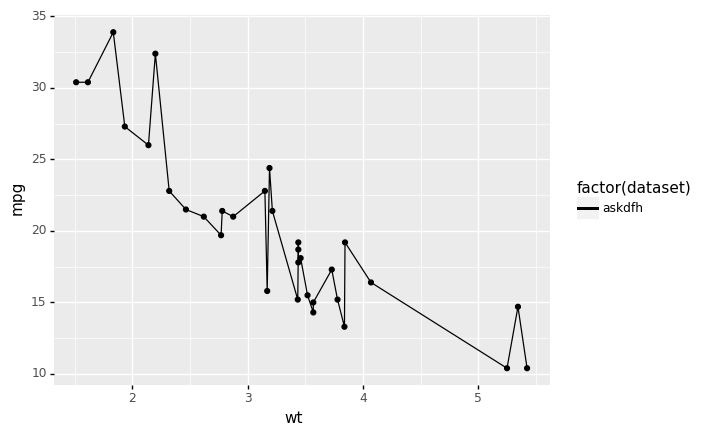

<ggplot: (8745116019375)>

In [84]:
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_line
from plotnine.data import mtcars
mtcars['dataset'] = "askdfh"
(ggplot(mtcars, aes('wt', 'mpg', linetype='factor(dataset)'))
 + geom_point() + geom_line())